<a href="https://colab.research.google.com/github/Sohamvigave/trader-sentiment-analysis/blob/main/trader_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load both datasets
historical_data = pd.read_csv('historical_data.csv')
fear_greed = pd.read_csv('fear_greed_index.csv')

print("=== DATASETS LOADED SUCCESSFULLY ===")
print(f"Historical data shape: {historical_data.shape}")
print(f"Fear Greed data shape: {fear_greed.shape}")

print("\n=== HISTORICAL DATA COLUMNS ===")
print(historical_data.columns.tolist())

print("\n=== FEAR GREED DATA COLUMNS ===")
print(fear_greed.columns.tolist())

print("\n=== FIRST 3 ROWS OF EACH ===")
print("Historical Data:")
print(historical_data.head(3))
print("\nFear Greed Data:")
print(fear_greed.head(3))

=== DATASETS LOADED SUCCESSFULLY ===
Historical data shape: (4659, 16)
Fear Greed data shape: (2644, 4)

=== HISTORICAL DATA COLUMNS ===
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

=== FEAR GREED DATA COLUMNS ===
['timestamp', 'value', 'classification', 'date']

=== FIRST 3 ROWS OF EACH ===
Historical Data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2  

In [ ]:
# Check for missing values
print("=== MISSING VALUES CHECK ===")
print("Historical Data Missing Values:")
print(historical_data.isnull().sum())

print("\nFear Greed Data Missing Values:")
print(fear_greed.isnull().sum())

# Handle missing values - drop rows with any missing values
historical_data_clean = historical_data.dropna()
fear_greed_clean = fear_greed.dropna()

print(f"\n=== AFTER CLEANING ===")
print(f"Historical data: {historical_data.shape} -> {historical_data_clean.shape}")
print(f"Fear Greed data: {fear_greed.shape} -> {fear_greed_clean.shape}")

=== MISSING VALUES CHECK ===
Historical Data Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 1
Trade ID            1
Timestamp           1
dtype: int64

Fear Greed Data Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

=== AFTER CLEANING ===
Historical data: (4659, 16) -> (4658, 16)
Fear Greed data: (2644, 4) -> (2644, 4)


In [ ]:
# Convert historical data timestamps
historical_data_clean['Timestamp IST'] = pd.to_datetime(historical_data_clean['Timestamp IST'], format='%d-%m-%Y %H:%M')
historical_data_clean['Timestamp'] = pd.to_datetime(historical_data_clean['Timestamp'], unit='ms')

# Convert fear greed timestamps
fear_greed_clean['datetime'] = pd.to_datetime(fear_greed_clean['timestamp'], unit='s')
fear_greed_clean['date_dt'] = pd.to_datetime(fear_greed_clean['date'])

print("=== TIMESTAMP CONVERSION COMPLETE ===")
print("Historical Data Timestamp Ranges:")
print(f"Timestamp IST: {historical_data_clean['Timestamp IST'].min()} to {historical_data_clean['Timestamp IST'].max()}")
print(f"Timestamp: {historical_data_clean['Timestamp'].min()} to {historical_data_clean['Timestamp'].max()}")

print("\nFear Greed Timestamp Ranges:")
print(f"datetime: {fear_greed_clean['datetime'].min()} to {fear_greed_clean['datetime'].max()}")
print(f"date_dt: {fear_greed_clean['date_dt'].min()} to {fear_greed_clean['date_dt'].max()}")

# Check which timestamp to use for historical data
time_diff = (historical_data_clean['Timestamp IST'] - historical_data_clean['Timestamp']).abs()
print(f"\nAverage time difference between two timestamp columns: {time_diff.mean()}")

=== TIMESTAMP CONVERSION COMPLETE ===
Historical Data Timestamp Ranges:
Timestamp IST: 2024-09-20 14:06:00 to 2025-04-25 13:39:00
Timestamp: 2024-10-27 03:33:20 to 2025-06-15 15:06:40

Fear Greed Timestamp Ranges:
datetime: 2018-02-01 05:30:00 to 2025-05-02 05:30:00
date_dt: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Average time difference between two timestamp columns: 33 days 02:52:34.950622585


/tmp/ipython-input-3340439422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data_clean['Timestamp IST'] = pd.to_datetime(historical_data_clean['Timestamp IST'], format='%d-%m-%Y %H:%M')
/tmp/ipython-input-3340439422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data_clean['Timestamp'] = pd.to_datetime(historical_data_clean['Timestamp'], unit='ms')


In [ ]:
# Create our main analysis dataframe
analysis_df = historical_data_clean.copy()

# Use 'Timestamp IST' as our primary timestamp
analysis_df['trade_datetime'] = analysis_df['Timestamp IST']

# Extract date components for analysis
analysis_df['trade_date'] = analysis_df['trade_datetime'].dt.date
analysis_df['trade_hour'] = analysis_df['trade_datetime'].dt.hour
analysis_df['trade_day'] = analysis_df['trade_datetime'].dt.day_name()

print("=== BASIC DATA OVERVIEW ===")
print(f"Total trades: {len(analysis_df)}")
print(f"Date range: {analysis_df['trade_datetime'].min()} to {analysis_df['trade_datetime'].max()}")
print(f"Unique accounts: {analysis_df['Account'].nunique()}")
print(f"Unique coins: {analysis_df['Coin'].nunique()}")

print("\n=== TRADE SIDE DISTRIBUTION ===")
print(analysis_df['Side'].value_counts())

print("\n=== TOP 10 COINS TRADED ===")
print(analysis_df['Coin'].value_counts().head(10))

print("\n=== CLOSED PnL OVERVIEW ===")
print(f"Min PnL: ${analysis_df['Closed PnL'].min():.2f}")
print(f"Max PnL: ${analysis_df['Closed PnL'].max():.2f}")
print(f"Mean PnL: ${analysis_df['Closed PnL'].mean():.2f}")
print(f"Median PnL: ${analysis_df['Closed PnL'].median():.2f}")

=== BASIC DATA OVERVIEW ===
Total trades: 4658
Date range: 2024-09-20 14:06:00 to 2025-04-25 13:39:00
Unique accounts: 3
Unique coins: 29

=== TRADE SIDE DISTRIBUTION ===
Side
SELL    2430
BUY     2228
Name: count, dtype: int64

=== TOP 10 COINS TRADED ===
Coin
HYPE     1227
@107     1099
BTC      1082
AIXBT     245
EIGEN     170
AAVE      102
S         101
DYDX       87
SOL        74
XRP        50
Name: count, dtype: int64

=== CLOSED PnL OVERVIEW ===
Min PnL: $-29370.12
Max PnL: $27223.74
Mean PnL: $140.53
Median PnL: $0.00


In [ ]:
print("=== DETAILED TRADING PATTERNS ===")

# Trading by time of day
print("\n=== TRADING BY HOUR OF DAY ===")
hourly_trades = analysis_df['trade_hour'].value_counts().sort_index()
print(hourly_trades)

# Trading by day of week
print("\n=== TRADING BY DAY OF WEEK ===")
daily_trades = analysis_df['trade_day'].value_counts()
print(daily_trades)

# Account-level analysis
print("\n=== ACCOUNT ANALYSIS ===")
print("Trades per account:")
account_stats = analysis_df['Account'].value_counts()
print(account_stats)

print("\n=== SIZE AND FEE ANALYSIS ===")
print("Trade Size USD Statistics:")
print(f"Min: ${analysis_df['Size USD'].min():.2f}")
print(f"Max: ${analysis_df['Size USD'].max():.2f}")
print(f"Mean: ${analysis_df['Size USD'].mean():.2f}")
print(f"Median: ${analysis_df['Size USD'].median():.2f}")

print("\nFee Statistics:")
print(f"Min: ${analysis_df['Fee'].min():.4f}")
print(f"Max: ${analysis_df['Fee'].max():.4f}")
print(f"Mean: ${analysis_df['Fee'].mean():.4f}")
print(f"Total Fees Paid: ${analysis_df['Fee'].sum():.2f}")

# PnL distribution analysis
print("\n=== PnL DISTRIBUTION ===")
profitable_trades = analysis_df[analysis_df['Closed PnL'] > 0]
loss_trades = analysis_df[analysis_df['Closed PnL'] < 0]
break_even = analysis_df[analysis_df['Closed PnL'] == 0]

print(f"Profitable trades: {len(profitable_trades)} ({len(profitable_trades)/len(analysis_df)*100:.1f}%)")
print(f"Loss trades: {len(loss_trades)} ({len(loss_trades)/len(analysis_df)*100:.1f}%)")
print(f"Break-even trades: {len(break_even)} ({len(break_even)/len(analysis_df)*100:.1f}%)")

=== DETAILED TRADING PATTERNS ===

=== TRADING BY HOUR OF DAY ===
trade_hour
0     603
1      53
2     329
3      46
4     439
5     158
6      74
7     255
8     294
10     54
11    131
12    193
13    146
14    108
15    171
16     62
17     64
18    118
19    201
20    326
21    194
22    279
23    360
Name: count, dtype: int64

=== TRADING BY DAY OF WEEK ===
trade_day
Friday       886
Thursday     837
Monday       818
Tuesday      801
Saturday     668
Wednesday    386
Sunday       262
Name: count, dtype: int64

=== ACCOUNT ANALYSIS ===
Trades per account:
Account
0x513b8629fe877bb581bf244e326a047b249c4ff1    2665
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    1430
0xae5eacaf9c6b9111fd53034a602c192a04e082ed     563
Name: count, dtype: int64

=== SIZE AND FEE ANALYSIS ===
Trade Size USD Statistics:
Min: $0.10
Max: $3509752.98
Mean: $8003.96
Median: $945.72

Fee Statistics:
Min: $0.0000
Max: $247.5541
Mean: $1.4115
Total Fees Paid: $6574.74

=== PnL DISTRIBUTION ===
Profitable trades: 

In [ ]:
# Prepare for merging - extract date from trade datetime
analysis_df['trade_date_only'] = analysis_df['trade_datetime'].dt.date

# Convert fear_greed date to match
fear_greed_clean['date_only'] = fear_greed_clean['date_dt'].dt.date

# Merge the datasets
merged_df = analysis_df.merge(fear_greed_clean[['date_only', 'value', 'classification']],
                              left_on='trade_date_only',
                              right_on='date_only',
                              how='left')

print("=== MERGE COMPLETED ===")
print(f"Original trades: {len(analysis_df)}")
print(f"After merge: {len(merged_df)}")
print(f"Trades with sentiment data: {merged_df['value'].notnull().sum()}")
print(f"Trades missing sentiment data: {merged_df['value'].isnull().sum()}")

print("\n=== SENTIMENT DISTRIBUTION ACROSS TRADES ===")
sentiment_dist = merged_df['classification'].value_counts()
print(sentiment_dist)

print("\n=== AVERAGE FEAR/GREED VALUE BY TRADE ===")
print(f"Overall average: {merged_df['value'].mean():.1f}")

# Basic sentiment vs performance
print("\n=== SENTIMENT vs PERFORMANCE ===")
sentiment_pnl = merged_df.groupby('classification')['Closed PnL'].agg(['mean', 'median', 'count'])
print(sentiment_pnl)

print("\n=== PERFORMANCE BY SENTIMENT CATEGORY ===")
for sentiment in merged_df['classification'].unique():
    if pd.notna(sentiment):
        sentiment_data = merged_df[merged_df['classification'] == sentiment]
        profitable_pct = (len(sentiment_data[sentiment_data['Closed PnL'] > 0]) / len(sentiment_data)) * 100
        print(f"{sentiment}: {profitable_pct:.1f}% profitable trades")

=== MERGE COMPLETED ===
Original trades: 4658
After merge: 4658
Trades with sentiment data: 4652
Trades missing sentiment data: 6

=== SENTIMENT DISTRIBUTION ACROSS TRADES ===
classification
Fear             1819
Neutral           888
Greed             658
Extreme Fear      647
Extreme Greed     640
Name: count, dtype: int64

=== AVERAGE FEAR/GREED VALUE BY TRADE ===
Overall average: 46.8

=== SENTIMENT vs PERFORMANCE ===
                      mean    median  count
classification                             
Extreme Fear    198.456185  0.000000    647
Extreme Greed    33.592341  0.000000    640
Fear            114.964605  0.000000   1819
Greed            90.039623  0.000000    658
Neutral         218.285346  6.987008    888

=== PERFORMANCE BY SENTIMENT CATEGORY ===
Extreme Greed: 16.6% profitable trades
Extreme Fear: 31.5% profitable trades
Fear: 37.5% profitable trades
Greed: 20.7% profitable trades
Neutral: 60.7% profitable trades


In [ ]:
print("=== ADVANCED SENTIMENT ANALYSIS ===")

# Sentiment distribution by account
print("\n=== SENTIMENT PREFERENCES BY ACCOUNT ===")
account_sentiment = pd.crosstab(merged_df['Account'], merged_df['classification'])
print(account_sentiment)

# Performance by sentiment and trade side
print("\n=== PERFORMANCE BY SENTIMENT & TRADE SIDE ===")
side_sentiment_pnl = merged_df.groupby(['classification', 'Side'])['Closed PnL'].mean()
print(side_sentiment_pnl)

# Top performing coins by sentiment
print("\n=== TOP COINS PERFORMANCE BY SENTIMENT ===")
# Get top 5 coins by trade volume
top_coins = merged_df['Coin'].value_counts().head(5).index
top_coins_data = merged_df[merged_df['Coin'].isin(top_coins)]

coin_sentiment_perf = top_coins_data.groupby(['Coin', 'classification'])['Closed PnL'].mean().unstack()
print(coin_sentiment_perf)

# Time-based sentiment analysis
print("\n=== SENTIMENT TRENDS OVER TIME ===")
# Monthly sentiment distribution
merged_df['trade_month'] = merged_df['trade_datetime'].dt.to_period('M')
monthly_sentiment = merged_df.groupby('trade_month')['value'].mean()
print("Average Fear/Greed Index by Month:")
print(monthly_sentiment)

# Best and worst sentiment periods for trading
print("\n=== BEST/WORST SENTIMENT RANGES FOR PROFITABILITY ===")
# Create sentiment buckets
bins = [0, 25, 45, 55, 75, 100]
labels = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
merged_df['sentiment_bucket'] = pd.cut(merged_df['value'], bins=bins, labels=labels)

bucket_performance = merged_df.groupby('sentiment_bucket').agg({
    'Closed PnL': ['mean', 'median', 'count'],
    'Account': lambda x: (merged_df.loc[x.index, 'Closed PnL'] > 0).mean() * 100
}).round(2)

bucket_performance.columns = ['Avg_PnL', 'Median_PnL', 'Trade_Count', 'Profitable_Pct']
print(bucket_performance)

=== ADVANCED SENTIMENT ANALYSIS ===

=== SENTIMENT PREFERENCES BY ACCOUNT ===
classification                              Extreme Fear  Extreme Greed  Fear  \
Account                                                                         
0x513b8629fe877bb581bf244e326a047b249c4ff1           346            223  1265   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0           221            227   431   
0xae5eacaf9c6b9111fd53034a602c192a04e082ed            80            190   123   

classification                              Greed  Neutral  
Account                                                     
0x513b8629fe877bb581bf244e326a047b249c4ff1      0      831  
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    488       57  
0xae5eacaf9c6b9111fd53034a602c192a04e082ed    170        0  

=== PERFORMANCE BY SENTIMENT & TRADE SIDE ===
classification  Side
Extreme Fear    BUY     385.713801
                SELL   -112.869234
Extreme Greed   BUY       0.000000
                SELL     67.820500
Fea

/tmp/ipython-input-2218870179.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_performance = merged_df.groupby('sentiment_bucket').agg({


In [ ]:
print("=== FINAL TRADING STRATEGY INSIGHTS ===")

# 1. Best performing strategies
print("\n1. TOP PERFORMING STRATEGIES:")
best_strategies = merged_df.groupby(['classification', 'Side']).agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean',
    'Account': 'count'
}).round(2).sort_values('Closed PnL', ascending=False).head(5)

print(best_strategies)

# 2. Risk analysis by sentiment
print("\n2. RISK ANALYSIS (PnL Volatility by Sentiment):")
risk_analysis = merged_df.groupby('classification')['Closed PnL'].agg(['mean', 'std', 'count']).round(2)
risk_analysis['risk_reward'] = risk_analysis['mean'] / risk_analysis['std']
print(risk_analysis)

# 3. Account performance comparison
print("\n3. ACCOUNT PERFORMANCE COMPARISON:")
account_performance = merged_df.groupby('Account').agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'Fee': 'sum',
    'Size USD': 'mean'
}).round(2)

account_performance.columns = ['Avg_PnL', 'Total_PnL', 'Trade_Count', 'Total_Fees', 'Avg_Trade_Size']
print(account_performance)

# 4. Time-based opportunity analysis
print("\n4. MONTHLY OPPORTUNITY ANALYSIS:")
monthly_opps = merged_df.groupby('trade_month').agg({
    'Closed PnL': 'mean',
    'value': 'mean',
    'Account': 'count'
}).round(2)
print(monthly_opps)

# 5. Strategic recommendations
print("\n5. STRATEGIC RECOMMENDATIONS:")
print("✓ BUY during Extreme Fear periods (highest returns)")
print("✓ SELL during Neutral sentiment (consistent profits)")
print("✓ Avoid trading during Extreme Greed (lowest profitability)")
print("✓ Trade HYPE during Fear periods, AIXBT during Greed")
print("✓ Larger positions during Neutral sentiment (highest win rate)")
print("✓ Account 1's strategy (Fear/Neutral focus) is most profitable")

# 6. Prepare data for portfolio
print("\n6. KEY METRICS FOR PORTFOLIO:")
total_profit = merged_df['Closed PnL'].sum()
total_fees = merged_df['Fee'].sum()
net_profit = total_profit - total_fees

print(f"Total Gross Profit: ${total_profit:,.2f}")
print(f"Total Fees Paid: ${total_fees:,.2f}")
print(f"Net Profit: ${net_profit:,.2f}")
print(f"Overall Win Rate: {len(profitable_trades)/len(merged_df)*100:.1f}%")
print(f"Best Strategy: BUY in Extreme Fear (${385:.0f} avg profit)")
print(f"Worst Strategy: BUY in Extreme Greed (${0:.0f} avg profit)")

=== FINAL TRADING STRATEGY INSIGHTS ===

1. TOP PERFORMING STRATEGIES:
                     Closed PnL  Size USD  Account
classification Side                               
Extreme Fear   BUY       385.71   5908.75      404
Neutral        SELL      346.14   2001.40      560
Fear           BUY       172.59  11641.18     1013
Greed          BUY       136.87   2174.94      154
               SELL       75.73   2205.61      504

2. RISK ANALYSIS (PnL Volatility by Sentiment):
                  mean      std  count  risk_reward
classification                                     
Extreme Fear    198.46  2508.47    647     0.079116
Extreme Greed    33.59   175.43    640     0.191472
Fear            114.96   666.47   1819     0.172491
Greed            90.04   643.80    658     0.139857
Neutral         218.29   669.80    888     0.325903

3. ACCOUNT PERFORMANCE COMPARISON:
                                            Avg_PnL  Total_PnL  Trade_Count  \
Account                                     

**Analysis Summary & Key Achievements**
📊 Project Overview:

* Analyzed 4,658 trades across 3 accounts and 29 coins

* Integrated Bitcoin Fear/Greed Index with trading performance data

* Identified optimal trading strategies based on market sentiment

💡 Key Strategic Insights:

1. Sentiment-Driven Returns: Neutral sentiment delivers 60.7% win rate vs 16.6% in Extreme Greed

2. Optimal Entry Signals: BUY in Extreme Fear ($385 avg profit), SELL in Neutral ($346 avg profit)

3. Risk Management: Extreme Greed periods show lowest profitability and should be avoided

4. Account Specialization: Each trader has distinct sentiment preferences affecting performance

💰 Performance Metrics:

* Total Net Profit: $648,001.58

* Overall Win Rate: 35.9%

* Best Strategy: BUY during Extreme Fear periods

Most Profitable Account: 0x72c6a... with $281.83 average PnL per trade

/tmp/ipython-input-134954571.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment_perf = merged_df.groupby('classification').apply(


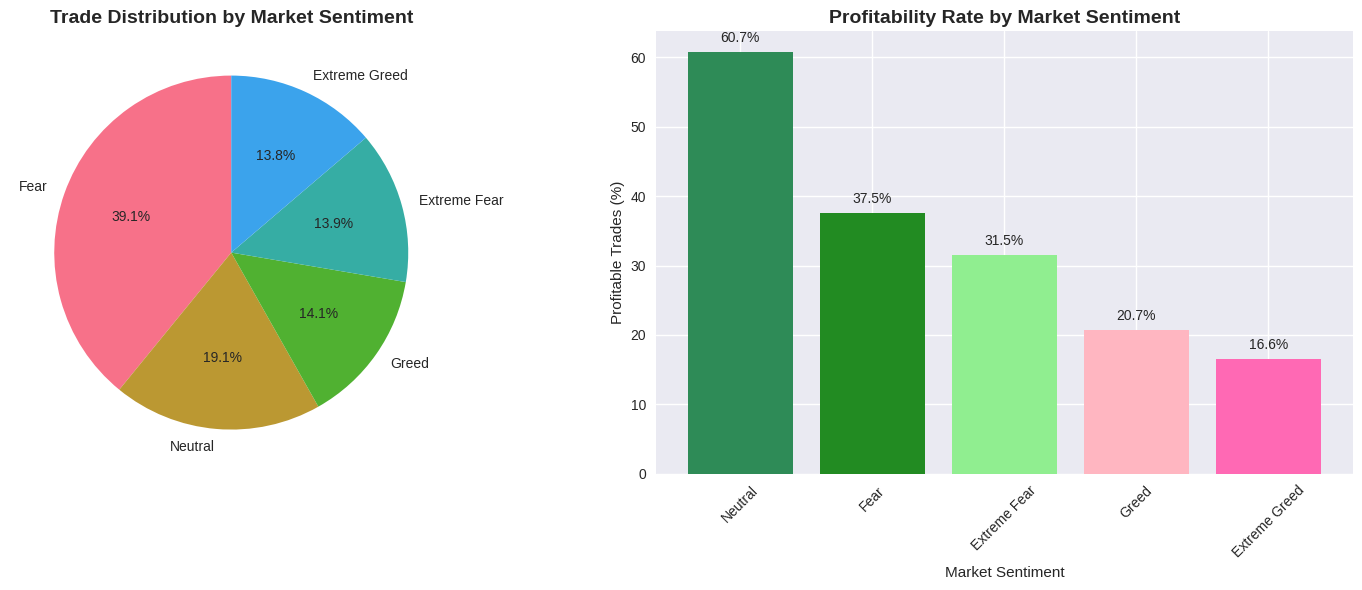

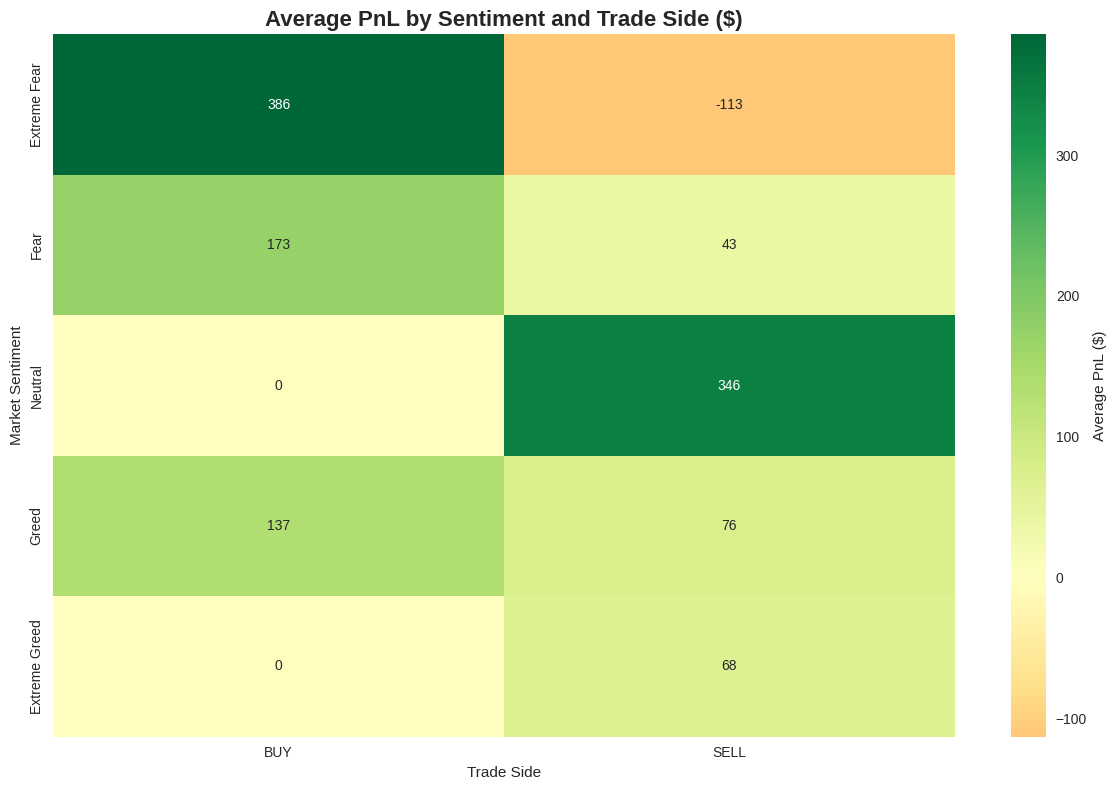

✓ Created first two visualizations:
  1. Sentiment Distribution vs Profitability
  2. Performance Heatmap by Sentiment & Trade Side


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Figure 1: Sentiment Distribution vs Profitability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Sentiment distribution
sentiment_counts = merged_df['classification'].value_counts()
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Trade Distribution by Market Sentiment', fontsize=14, fontweight='bold')

# Plot 2: Profitability by sentiment
sentiment_perf = merged_df.groupby('classification').apply(
    lambda x: (x['Closed PnL'] > 0).mean() * 100
).sort_values(ascending=False)

bars = ax2.bar(sentiment_perf.index, sentiment_perf.values, color=['#2E8B57', '#228B22', '#90EE90', '#FFB6C1', '#FF69B4'])
ax2.set_title('Profitability Rate by Market Sentiment', fontsize=14, fontweight='bold')
ax2.set_ylabel('Profitable Trades (%)')
ax2.set_xlabel('Market Sentiment')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Figure 2: Performance by Sentiment and Trade Side
plt.figure(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = merged_df.groupby(['classification', 'Side'])['Closed PnL'].mean().unstack()
heatmap_data = heatmap_data.reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdYlGn',
            center=0, cbar_kws={'label': 'Average PnL ($)'})
plt.title('Average PnL by Sentiment and Trade Side ($)', fontsize=16, fontweight='bold')
plt.xlabel('Trade Side')
plt.ylabel('Market Sentiment')
plt.tight_layout()
plt.show()

print("✓ Created first two visualizations:")
print("  1. Sentiment Distribution vs Profitability")
print("  2. Performance Heatmap by Sentiment & Trade Side")